Read `about_the_implementation.md` for more info.

# Prior

In [20]:
import numpy as np
from matplotlib import pyplot as plt

import os
os.chdir('../../../..')
print(os.getcwd())

from src.smc_2324_project.simulate.generate_dataset import *
from src.smc_2324_project.tempering.base_dist import *
from src.smc_2324_project.tempering.tempering import *

import particles
from particles.smc_samplers import TemperingBridge

C:\Users\guspo\Augustin\X


In [21]:
# hyperparameters
n, k, p = 40, 4, 4
#gamma_0 = np.array([0.6,0.6,0.6,1, 0, 3, 1.1, 2.2, 0.1, -0.3])
gamma_0 = np.random.normal(0, 1, (k * (k + 1)) // 2 + 4)
V_0 = np.eye(len(gamma_0))
e_0 = 3 * np.ones(k)

# prior
theta_prior = define_theta_prior(gamma_0, V_0, e_0)
prior = define_prior(theta_prior, n)

# Dataset

In [22]:
# hyperparameters to generating the dataset
n, k, p = 40, 3, 4
gamma_0 = np.array([0.6,0.6,0.6,1, 0, 3, 1.1, 2.2, 0.1, -0.3])
V_0 = np.eye(len(gamma_0))
e_0 = 3 * np.ones(k)

In [23]:
# generate dataset
alpha, beta, nu = generate_network_params(k, gamma_0, V_0, e_0)
X = generate_covariates(n, p)
sample_from_network((alpha, beta, nu), X)
theta = (alpha,beta,nu)
Y = sample_from_network(theta,X, return_Z=False)

# Logtarget and model

In [24]:
compute_llh_target = define_llh_target(prior, X, Y, k)

In [25]:
from particles.smc_samplers import TemperingBridge

class ToyBridge(TemperingBridge):
    def logtarget(self, theta):
        return compute_llh_target(theta)

In [26]:
toy_bridge = ToyBridge(base_dist=prior)

# Move

In [27]:
move = FixedLenMCMCSequence(mcmc=CustomGibbs(k, e_0, e_0), len_chain=5)

# AdaptiveTempering

In [28]:

# finally
fk_tpr = FlexibeAdaptiveTempering(model=toy_bridge, len_chain=100, 
                                  move=move, wastefree=False,
                                  tempering_step_size = 0.1) # tempering_step_size = 1-tau_1
alg = particles.SMC(fk=fk_tpr, N=200, ESSrmin=0.8,
                    store_history=True, verbose=True)
#alg.run()

# Posterior inference

In [ ]:
list_lpy=[]
list_k=[k for k in range(2,11)]
for k in list_k:
    #hyperparameters
    gamma_0 = np.random.normal(0, 3, (k * (k + 1)) // 2 + 4)
    V_0 = np.eye(len(gamma_0))
    e_0 = 3 * np.ones(k)

    # prior
    theta_prior = define_theta_prior(gamma_0, V_0, e_0)
    prior = define_prior(theta_prior, n)
    
    #logtarget and model
    compute_llh_target = define_llh_target(prior, X, Y, k)
    toy_bridge = ToyBridge(base_dist=prior)
    
    #move
    move = FixedLenMCMCSequence(mcmc=CustomGibbs(k, e_0, e_0), len_chain=5)
    
    # adaptative tempering
    fk_tpr = FlexibeAdaptiveTempering(model=toy_bridge, len_chain=100, 
                                      move=move, wastefree=False,
                                      tempering_step_size = 0.5) # tempering_step_size = 1-tau_1
    alg = particles.SMC(fk=fk_tpr, N=200, ESSrmin=0.8,
                        store_history=True, verbose=True)
    alg.run()
    
    #save data
    lpy=0
    for wgt in alg.hist.wgts:
        #lpy+=np.log(sum(np.exp(wgt.lw)))
        lpy+=max(wgt.lw) + np.log(sum(np.exp(wgt.lw-max(wgt.lw))))
    print(lpy)
    list_lpy.append(lpy)

t=0, ESS=100.00, tempering exponent=6.24e-09
t=1, Metropolis acc. rate (over 1 steps): 0.065, ESS=100.00, tempering exponent=1.12e-07
t=2, Metropolis acc. rate (over 1 steps): 0.065, ESS=100.00, tempering exponent=6.65e-07
t=3, Metropolis acc. rate (over 1 steps): 0.065, ESS=100.00, tempering exponent=2.65e-06
t=4, Metropolis acc. rate (over 1 steps): 0.065, ESS=100.00, tempering exponent=5.44e-06
t=5, Metropolis acc. rate (over 1 steps): 0.075, ESS=100.00, tempering exponent=7.93e-06
t=6, Metropolis acc. rate (over 1 steps): 0.095, ESS=100.00, tempering exponent=1.06e-05
t=7, Metropolis acc. rate (over 1 steps): 0.080, ESS=100.00, tempering exponent=1.39e-05
t=8, Metropolis acc. rate (over 1 steps): 0.050, ESS=100.00, tempering exponent=1.9e-05
t=9, Metropolis acc. rate (over 1 steps): 0.060, ESS=100.00, tempering exponent=2.74e-05
t=10, Metropolis acc. rate (over 1 steps): 0.035, ESS=100.00, tempering exponent=3.6e-05
t=11, Metropolis acc. rate (over 1 steps): 0.045, ESS=100.00, temp

# Plot

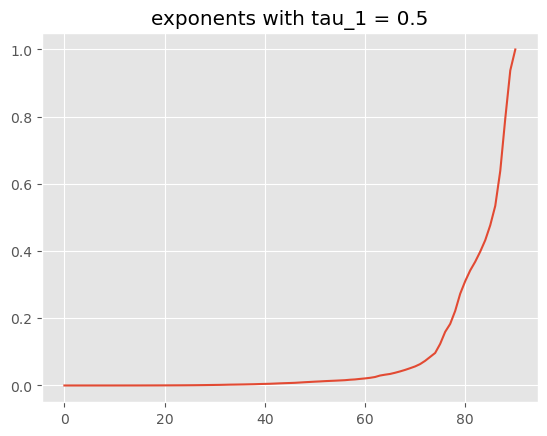

In [76]:
# exponents
exponents = alg.X.shared["exponents"]
plt.plot(exponents)
plt.title("exponents with tau_1 = 0.5")
plt.show()

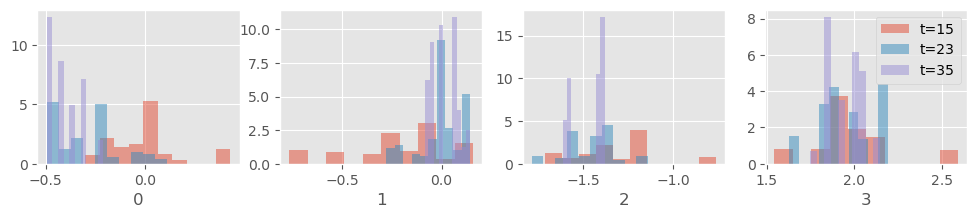

In [74]:
# beta distribution
plt.style.use('ggplot')
fig = plt.figure(figsize=(12, 2))
for beta_idx in range(4):
    plt.subplot(1, 4, beta_idx+1)
    for t in [15, 23, 35]:
        beta_i = alg.hist.X[t].theta["theta"]["gamma"][:,k*(k+1)//2+beta_idx]
        weights = alg.hist.wgts[t].W
        plt.hist(beta_i, weights=weights, label="t=%i" % t, 
                 alpha=0.5, density=True)
    plt.xlabel(beta_idx)
plt.legend()

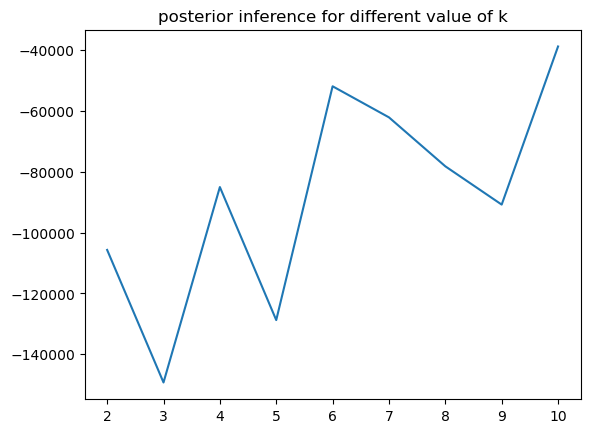

In [ ]:
# exponents
plt.plot(list_k,list_lpy)
plt.title("posterior inference for different value of k")
plt.show()

In [1]:
import random

# Fixer la graine aléatoire pour la première partie du code
random.seed(42)

# Votre code aléatoire ici
nombre_aleatoire_partie1 = random.randint(1, 100)
print(nombre_aleatoire_partie1)

# Réinitialiser la graine aléatoire pour permettre une séquence différente
random.seed()

# Suite du code sans la graine fixée
nombre_aleatoire_partie2 = random.randint(1, 100)
print(nombre_aleatoire_partie2)

82
86
